## Import Library

In [1]:
import string
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_columns = 50
sns.set(style='darkgrid')
%matplotlib inline

## Load Data

In [5]:
# normal, fraud, promo
email = pd.read_csv('./Dataset/spam text message 20170820 - Data.csv')
email

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


## Exploratory Data Analysis

In [6]:
email.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [7]:
email.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [8]:
email['length'] = email['Message'].apply(len)
email.head()

,Category,Message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [10]:
email['Category'].sort_values().unique().tolist()

['ham', 'spam']

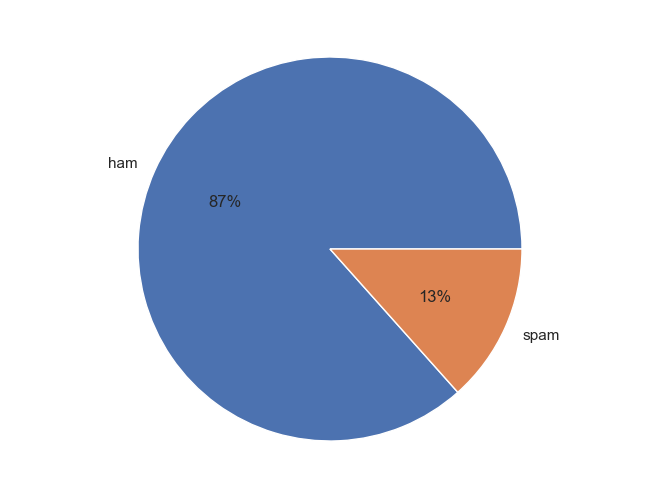

In [11]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
labels = email['Category'].sort_values().unique().tolist()
email_val_count = email.Category.value_counts()
ax.pie(email_val_count, labels=labels, autopct='%.0f%%')
plt.show()

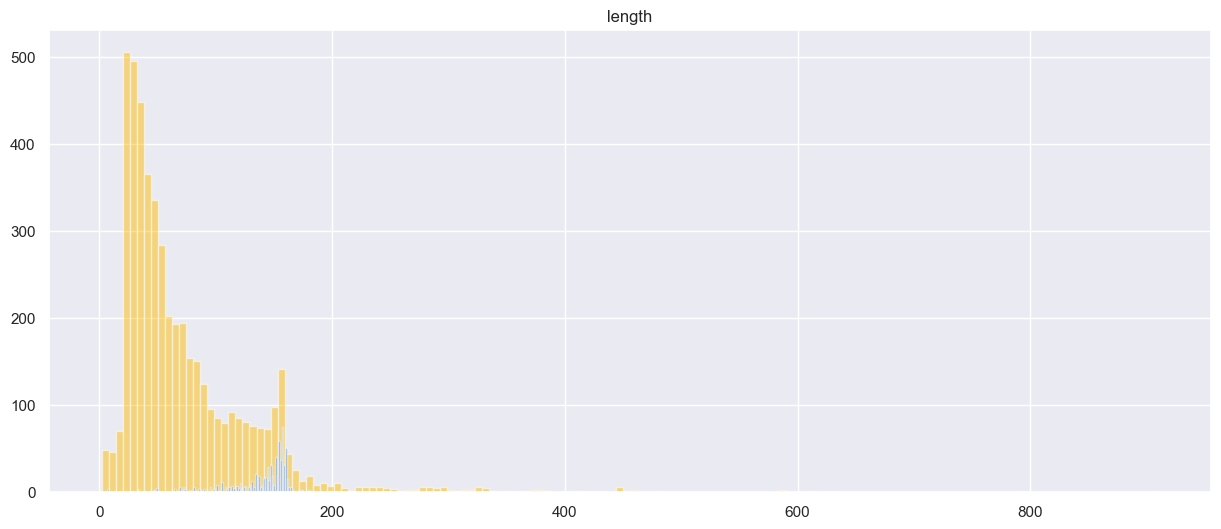

In [12]:
feature = ['length']
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
email[email.Category == 'ham'][feature].hist(bins=150, color='#FFBE0B', alpha=0.5, ax=ax)
email[email.Category == 'spam'][feature].hist(bins=150, color='#3A86FF', alpha=0.5, ax=ax)
plt.show()

## Feature Engineering

Tahapan feature engineering:
1. Lower Casing
2. Remove Number
3. Remove Punctuation

### Lower Casing

In [13]:
email['message_lower'] = email['Message'].apply(lambda text: text.lower())
email[['Message','message_lower']].head()

,Message,message_lower
0,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ..."
1,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,U dun say so early hor... U c already then say...,u dun say so early hor... u c already then say...
4,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro..."


### Remove Punctuation

In [14]:
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    text = re.sub('\w*\d\w*', '', text)
    return text.translate(str.maketrans('','', PUNCT_TO_REMOVE))

email['message_rm_punct'] = email['message_lower'].apply(remove_punctuation)
email[['message_lower','message_rm_punct']].head()

,message_lower,message_rm_punct
0,"go until jurong point, crazy.. available only ...",go until jurong point crazy available only in ...
1,ok lar... joking wif u oni...,ok lar joking wif u oni
2,free entry in 2 a wkly comp to win fa cup fina...,free entry in a wkly comp to win fa cup final...
3,u dun say so early hor... u c already then say...,u dun say so early hor u c already then say
4,"nah i don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...


## Text Preprocessing

Tahapan preprocessing teks:
- Tokenization
- Stopword Removal
- Stemming
- Lemmatization

In [ ]:
nltk.download('stopwords')
", ".join(stopwords.words('english'))

### Tokenizer

In [15]:
def tokenizer(text):
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    tokenizer = tokenizer.tokenize(text)
    return tokenizer

email['message_tokenizer'] = email['message_rm_punct'].apply(tokenizer)
email[['message_rm_punct','message_tokenizer']].head()

,message_rm_punct,message_tokenizer
0,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o..."
1,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,free entry in a wkly comp to win fa cup final...,"[free, entry, in, a, wkly, comp, to, win, fa, ..."
3,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t..."
4,nah i dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l..."


### Stopword Removal

In [16]:
def stopwords_removal(text):
    list_stopwords = set(stopwords.words('english'))
    stopwords_rmv = [s for s in text if s not in list_stopwords]
    stopwords_rmv = ' '.join(stopwords_rmv)
    return stopwords_rmv

email['message_stopword_rmv'] = email['message_tokenizer'].apply(stopwords_removal)
email[['message_tokenizer','message_stopword_rmv']].head()

,message_tokenizer,message_stopword_rmv
0,"[go, until, jurong, point, crazy, available, o...",go jurong point crazy available bugis n great ...
1,"[ok, lar, joking, wif, u, oni]",ok lar joking wif u oni
2,"[free, entry, in, a, wkly, comp, to, win, fa, ...",free entry wkly comp win fa cup final tkts may...
3,"[u, dun, say, so, early, hor, u, c, already, t...",u dun say early hor u c already say
4,"[nah, i, dont, think, he, goes, to, usf, he, l...",nah dont think goes usf lives around though


### Stemming

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')

In [17]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    return " ".join([ps.stem(word) for word in text.split()])

email['message_stemming'] = email['message_stopword_rmv'].apply(simple_stemmer)
email[['message_stopword_rmv','message_stemming']].head()

,message_stopword_rmv,message_stemming
0,go jurong point crazy available bugis n great ...,go jurong point crazi avail bugi n great world...
1,ok lar joking wif u oni,ok lar joke wif u oni
2,free entry wkly comp win fa cup final tkts may...,free entri wkli comp win fa cup final tkt may ...
3,u dun say early hor u c already say,u dun say earli hor u c alreadi say
4,nah dont think goes usf lives around though,nah dont think goe usf live around though


### Label Encoder

In [18]:
email['Category'] = LabelBinarizer().fit_transform(email['Category'])
email[['message_stemming','Category']].head()

,message_stemming,Category
0,go jurong point crazi avail bugi n great world...,0
1,ok lar joke wif u oni,0
2,free entri wkli comp win fa cup final tkt may ...,1
3,u dun say earli hor u c alreadi say,0
4,nah dont think goe usf live around though,0


## Splitting Data

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
x_train, x_test, y_train, y_test = train_test_split(email['message_stemming'],
                                                    email['Category'], 
                                                    test_size=0.2,
                                                    random_state=45)

## Feature Extraction

### Term Frequency–Inverse Document Frequency (TF-IDF)

In [21]:
tfidf = TfidfVectorizer()
tfidf.fit(x_train.values)
train_tfidf = tfidf.transform(x_train.values)
test_tfidf = tfidf.transform(x_test.values)

# print(tfidf.get_feature_names())

In [23]:
print(train_tfidf)

  (0, 4827)	0.5497137650709447
  (0, 2877)	0.5580458368163193
  (0, 2477)	0.4876874850926067
  (0, 731)	0.385435516510283
  (1, 2877)	0.4816926665256813
  (1, 2477)	0.42096091329283325
  (1, 1781)	0.692874633219744
  (1, 731)	0.3326993043810699
  (2, 6103)	0.5149288898190023
  (2, 4502)	0.42113418140606357
  (2, 3944)	0.4405983420187108
  (2, 3637)	0.3882854118441212
  (2, 2093)	0.28480870350435616
  (2, 713)	0.3626096827841012
  (3, 5526)	0.4856442821828846
  (3, 5505)	0.1722008610746753
  (3, 5222)	0.169682763789682
  (3, 4576)	0.26850108968048125
  (3, 3496)	0.18572706015321092
  (3, 3388)	0.32608247853766625
  (3, 3255)	0.32608247853766625
  (3, 3006)	0.20844347954716033
  (3, 2943)	0.16338629029742582
  (3, 2513)	0.32608247853766625
  (3, 2165)	0.21482541305700817
  :	:
  (4453, 4763)	0.40764138129285266
  (4453, 4491)	0.2137729713104041
  (4453, 3152)	0.37361430895331516
  (4453, 3035)	0.10373613035227003
  (4453, 1928)	0.2137729713104041
  (4453, 1183)	0.19675943514063532
  (445

In [24]:
train_tfidf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [25]:
df_tfidf = pd.DataFrame(train_tfidf.todense().T,
                        index=tfidf.get_feature_names(),
                        columns=[f'D{i+1}' for i in range(len(train_tfidf.toarray()))])
df_tfidf.sample(5)

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,D16,D17,D18,D19,D20,D21,D22,D23,D24,D25,...,D4433,D4434,D4435,D4436,D4437,D4438,D4439,D4440,D4441,D4442,D4443,D4444,D4445,D4446,D4447,D4448,D4449,D4450,D4451,D4452,D4453,D4454,D4455,D4456,D4457
cred,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
system,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
el,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ger,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chinki,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Modeling

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

### Logostic Regression

In [27]:
lr_model = RandomForestClassifier()
lr_model.fit(train_tfidf, y_train)

RandomForestClassifier()

In [28]:
lr_model.score(train_tfidf, y_train), lr_model.score(test_tfidf, y_test)

(0.9997756338344178, 0.967713004484305)

In [29]:
pred = lr_model.predict(test_tfidf)
print(classification_report(y_test, pred, target_names=['ham','spam']))

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       966
        spam       0.99      0.77      0.86       149

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.97      1115



### Multinomial Naive Bayes

In [30]:
multinomial_nb = MultinomialNB()
multinomial_nb.fit(train_tfidf, y_train)

MultinomialNB()

In [31]:
multinomial_nb.score(train_tfidf, y_train), multinomial_nb.score(test_tfidf, y_test)

(0.9766659187794481, 0.9533632286995516)

In [32]:
pred = multinomial_nb.predict(test_tfidf)
print(classification_report(y_test, pred, target_names=['ham','spam']))

              precision    recall  f1-score   support

         ham       0.95      1.00      0.97       966
        spam       1.00      0.65      0.79       149

    accuracy                           0.95      1115
   macro avg       0.97      0.83      0.88      1115
weighted avg       0.96      0.95      0.95      1115



### Random Fores Classifier

In [33]:
random_fores = RandomForestClassifier()
random_fores.fit(train_tfidf, y_train)

RandomForestClassifier()

In [34]:
random_fores.score(train_tfidf, y_train), random_fores.score(test_tfidf, y_test)

(0.9997756338344178, 0.9668161434977578)

In [35]:
pred = random_fores.predict(test_tfidf)
print(classification_report(y_test, pred, target_names=['ham','spam']))

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       966
        spam       0.99      0.76      0.86       149

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.96      1115

